# Baseline Model

In [11]:
import json
import os

from pathlib import Path

import albumentations as albu  
import numpy as np  
import pandas as pd
import pytorch_lightning as pl  
import segmentation_models_pytorch as smp  
import sklearn
import torch 

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from rasterio import features
from shapely.geometry import Polygon, shape
from skimage import measure
from tqdm import tqdm

import sklearn.model_selection

import rasterio
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt

In [2]:
seed_everything(42)

Seed set to 42


42

In [3]:
data_root = Path("./data")

class_names = ["grassland_shrubland", "logging", "mining", "plantation"]

epochs = 50

In [4]:
def load_mask(mask_path):
    mask = np.load(mask_path)  # (4, H, W), uint8
    assert mask.shape == (4, 1024, 1024)
    mask = mask.transpose(1, 2, 0)  # (H, W, 4)
    return mask.astype(np.float32) / 255.0  # normalize to [0, 1]


def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()  # (12, H, W)
    image = np.transpose(image, (1, 2, 0))  # (H, W, 12)
    assert image.shape == (1024, 1024, 12)
    image = np.nan_to_num(image)  # replace NaN with 0
    return image.astype(np.float32)


def normalize_image(image):
    # mean of train images
    mean = np.array(
        [
            285.8190561180765,
            327.22091430696577,
            552.9305957826701,
            392.1575148484924,
            914.3138803812591,
            2346.1184507500043,
            2884.4831706095824,
            2886.442429854111,
            3176.7501338557763,
            3156.934442092072,
            1727.1940075511282,
            848.573373995044,
        ],
        dtype=np.float32
    )

    # std of train images
    std = np.array(
        [
            216.44975668759372,
            269.8880248304874,
            309.92790753407064,
            397.45655590699,
            400.22078920482215,
            630.3269651264278,
            789.8006920468097,
            810.4773696969773,
            852.9031432100967,
            807.5976198303886,
            631.7808113929271,
            502.66788721341396,
        ],
        dtype=np.float32
    )
    
    mean = mean.reshape(12, 1, 1)
    std = std.reshape(12, 1, 1)

    return (image - mean) / std


class TrainValDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, sample_indices, augmentations=None):
        self.image_paths, self.mask_paths = [], []
        for i in sample_indices:
            self.image_paths.append(data_root / "train_images" / f"train_{i}.tif")
            self.mask_paths.append(data_root / "train_masks" / f"train_{i}.npy")
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        sample = {
            "image": load_image(self.image_paths[idx]),
            "mask": load_mask(self.mask_paths[idx]),
        }

        if self.augmentations is not None:
            sample = self.augmentations(**sample)

        sample["image"] = sample["image"].transpose(2, 0, 1)  # (12, H, W)
        sample["mask"] = sample["mask"].transpose(2, 0, 1)  # (4, H, W)

        sample["image"] = normalize_image(sample["image"])

        # add metadata
        sample["image_path"] = str(self.image_paths[idx])
        sample["mask_path"] = str(self.mask_paths[idx])

        return sample

In [5]:
class Model(pl.LightningModule):
    def __init__(self, num_classes=4, in_channels=12):
        super().__init__()
        
        # Define segmentation model 
        self.model = smp.Unet(
            encoder_name="resnet34",  # Resnet34 encoder
            encoder_weights="imagenet", # default encoder for image segmentation
            in_channels=in_channels,
            classes=num_classes,
        )

        # Loss functions
        self.dice_loss_fn = smp.losses.DiceLoss(mode=smp.losses.MULTILABEL_MODE, from_logits=True)
        self.bce_loss_fn = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.0)

    def forward(self, image):
        return self.model(image)  # Returns logits
    
    def shared_step(self, batch, stage):
        image, mask = batch["image"], batch["mask"]
        logits_mask = self.forward(image)
        loss = self.dice_loss_fn(logits_mask, mask) + self.bce_loss_fn(logits_mask, mask)
        
        # Compute segmentation stats
        prob_mask = logits_mask.sigmoid()
        tp, fp, fn, tn = smp.metrics.get_stats(
            (prob_mask > 0.5).long(), mask.long(), mode=smp.losses.MULTILABEL_MODE
        )
        
        # Log loss
        self.log(f"{stage}/loss", loss, prog_bar=True, sync_dist=True)
        self.log(f"{stage}/tp", tp.sum().float(), sync_dist=True)
        self.log(f"{stage}/fp", fp.sum().float(), sync_dist=True)
        self.log(f"{stage}/fn", fn.sum().float(), sync_dist=True)
        self.log(f"{stage}/tn", tn.sum().float(), sync_dist=True)
        
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self.shared_step(batch, "val")
    
    def shared_epoch_end(self, stage):
        tp = self.trainer.callback_metrics[f"{stage}/tp"].item()
        fp = self.trainer.callback_metrics[f"{stage}/fp"].item()
        fn = self.trainer.callback_metrics[f"{stage}/fn"].item()
        tn = self.trainer.callback_metrics[f"{stage}/tn"].item()
        
        f1_scores = {
            class_name: smp.metrics.f1_score(torch.tensor(tp), torch.tensor(fp), torch.tensor(fn), torch.tensor(tn), reduction="macro-imagewise")
            for i, class_name in enumerate(class_names)
        }
        
        # Log F1 scores
        for class_name, f1 in f1_scores.items():
            self.log(f"{stage}/f1_{class_name}", f1, sync_dist=True)
        
        # Log average F1 score
        f1_avg = torch.stack(list(f1_scores.values())).mean()
        self.log(f"{stage}/f1_avg", f1_avg, prog_bar=True, sync_dist=True)

    def on_train_epoch_end(self):
        self.shared_epoch_end("train")

    def on_validation_epoch_end(self):
        self.shared_epoch_end("val")
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-2)
        scheduler = CosineAnnealingLR(optimizer, T_max=200, eta_min=0.0)  
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}

In [6]:
train_output_dir = data_root / "training_result"

# split train_images into train-set and val-set
sample_indices = list(range(176))  # train_0.tif to train_175.tif
train_indices, val_indices = sklearn.model_selection.train_test_split(sample_indices, test_size=0.2, random_state=42)

# augmentations applied only to train-set
augmentations = albu.Compose(
    [
        # Shift, scale, and rotate with Affine instead of ShiftScaleRotate for better control
        albu.Affine(
            p=0.5,
            scale=(0.9, 1.1),
            translate_percent=(-0.0625, 0.0625),
            rotate=(-15, 15),
            cval=0,  # Constant border padding
        ),
        # random crop
        albu.RandomCrop(
            p=1,
            width=512,
            height=512,
        ),
        # flip, transpose, and rotate90
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.Transpose(p=0.5),
        albu.RandomRotate90(p=0.5),

        # More spectral augmentations
        albu.RandomBrightnessContrast(p=0.5),
        albu.ChannelShuffle(p=0.3),
        albu.GaussianBlur(p=0.3),
        albu.GaussNoise(p=0.3),
    ]
)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(
    TrainValDataset(
        data_root,
        train_indices,
        augmentations=augmentations,
    ),
    batch_size=12,
    num_workers=0,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    TrainValDataset(
        data_root,
        val_indices,
        augmentations=None,
    ),
    batch_size=4,
    num_workers=0,
    shuffle=False,
)

# prepare trainer
trainer = Trainer(
    max_epochs=epochs,
    callbacks = [
        # save model with best validation F1 score
        ModelCheckpoint(
            dirpath=train_output_dir,
            filename="best_f1_Baseline(resnet_imagenet)",
            save_weights_only=True,
            save_top_k=1,
            monitor="val/f1_avg",
            mode="max",
            save_last=False,
        ),
        LearningRateMonitor(logging_interval="step"),
    ],
    
    precision="16-mixed",
    deterministic=True,
    benchmark=False,
    sync_batchnorm=False,
    check_val_every_n_epoch=5,
    default_root_dir=os.getcwd(),
    accelerator="gpu",
    devices=[0,],
    log_every_n_steps=5,
)

# prepare model
model = Model()

C:\Users\Shreew\AppData\Local\Temp\ipykernel_19744\1975789095.py:11: UserWarning: Argument 'cval' is not valid and will be ignored.
  albu.Affine(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
# start training
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\Shreew\anaconda3\envs\INF367A\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Shreew\Desktop\Python Code\INF367A\data\training_result exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                  | Params | Mode 
---------------------------------------------------------------
0 | model        | Unet                  | 24.5 M | train
1 | dice_loss_fn | DiceLoss              | 0      | train
2 | bce_loss_fn  | SoftBCEWithLogitsLoss | 0      | train
---------------------------------------------------------------
24.5 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Shreew\anaconda3\envs\INF367A\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s]

c:\Users\Shreew\anaconda3\envs\INF367A\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\Shreew\anaconda3\envs\INF367A\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 12/12 [01:03<00:00,  0.19it/s, v_num=28, train/loss=1.210, train/f1_avg=0.154, val/loss=1.010, val/f1_avg=0.488]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 12/12 [01:03<00:00,  0.19it/s, v_num=28, train/loss=1.210, train/f1_avg=0.154, val/loss=1.010, val/f1_avg=0.488]


In [7]:
def run_inference(model, loader, pred_output_dir):
    pred_output_dir = Path(pred_output_dir)
    pred_output_dir.mkdir(exist_ok=True, parents=True)

    for batch in tqdm(loader):
        img = batch["image"].cuda()

        with torch.no_grad():
            logits_mask = model(img)
            prob_mask = logits_mask.sigmoid()

        # save prob mask as numpy array
        for i in range(img.size(0)):
            file_name = os.path.basename(batch["image_path"][i])
            prob_mask_i = prob_mask[i].cpu().numpy()  # (4, 1024, 1024)

            np.save(
                pred_output_dir / file_name.replace(".tif", ".npy"),
                prob_mask_i.astype(np.float16),
            )

In [8]:
# load best checkpoint and run inference on val-set
del model

model = Model()
model.load_state_dict(torch.load(train_output_dir / "best_f1_Baseline(resnet_imagenet).ckpt")["state_dict"])
model = model.cuda()
model.eval()

val_pred_dir = data_root / "val_preds"
run_inference(model, val_loader, val_pred_dir)

C:\Users\Shreew\AppData\Local\Temp\ipykernel_19744\142727865.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(train_output_dir / "best_f1

In [10]:
def compute_f1_score(pred_mask, truth_mask):
    # `pred_mask` is a binary numpy array of shape (H, W) = (1024, 1024)
    # `truth_mask` is a binaru numpy array of shape (H, W) = (1024, 1024)
    assert pred_mask.shape == (1024, 1024), f"{pred_mask.shape=}"
    assert truth_mask.shape == (1024, 1024), f"{truth_mask.shape=}"

    tp = ((pred_mask > 0) & (truth_mask > 0)).sum()
    fp = ((pred_mask > 0) & (truth_mask == 0)).sum()
    fn = ((pred_mask == 0) & (truth_mask > 0)).sum()
    precision = tp / (tp + fp) if tp + fp > 0 else 1  # if no prediction, precision is considered as 1
    recall = tp / (tp + fn) if tp + fn > 0 else 1  # if no ground truth, recall is considered as 1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0  # if either precision or recall is 0, f1 is 0

    return f1


score_thresh = 0.5  # threshold to binarize the prediction mask
min_area = 10000  # if the predicted area of a class is less than this, submit an zero mask because small predicted areas are often false positives

val_f1_scores = {}
for idx in sorted(val_indices):
    fn = f"train_{idx}"
    # prepare prediction mask
    pred_mask = np.load(val_pred_dir / f"{fn}.npy")  # (4, 1024, 1024)
    pred_mask = pred_mask > score_thresh  # binarize
    # prepare ground truth mask
    truth_mask = np.load(data_root / "train_masks" / f"{fn}.npy")  # (4, 1024, 1024)
    # compute f1 score for each class
    val_f1_scores[fn] = {}
    for i, class_name in enumerate(class_names):
        pred_for_a_class = pred_mask[i]
        if pred_for_a_class.sum() < min_area:
            pred_for_a_class = np.zeros_like(pred_for_a_class)  # set all to zero if the predicted area is less than `min_area`
        val_f1_scores[fn][class_name] = compute_f1_score(pred_for_a_class, truth_mask[i])
val_f1_scores = pd.DataFrame(val_f1_scores).T

# add a column for average of all the 4 classes
val_f1_scores["all_classes"] = val_f1_scores.mean(axis=1)
# add a row for average of all the val images
val_f1_scores.loc["all_images"] = val_f1_scores.mean()

print(f"val f1 score: {val_f1_scores.loc['all_images', 'all_classes']:.4f}")

val_f1_scores

val f1 score: 0.5737


,grassland_shrubland,logging,mining,plantation,all_classes
train_9,0.000000,1.000000,1.000000,0.000000,0.500000
train_12,1.000000,1.000000,1.000000,0.000000,0.750000
train_15,0.000000,1.000000,1.000000,0.564147,0.641037
train_16,0.000000,1.000000,1.000000,0.702635,0.675659
train_18,0.000000,1.000000,1.000000,0.803025,0.700756
train_19,1.000000,1.000000,1.000000,0.804331,0.951083
train_24,1.000000,1.000000,1.000000,0.805569,0.951392
train_29,1.000000,1.000000,0.000000,0.554887,0.638722
train_30,0.000000,1.000000,1.000000,0.000000,0.500000
train_31,0.000000,0.000000,0.000000,0.000000,0.000000


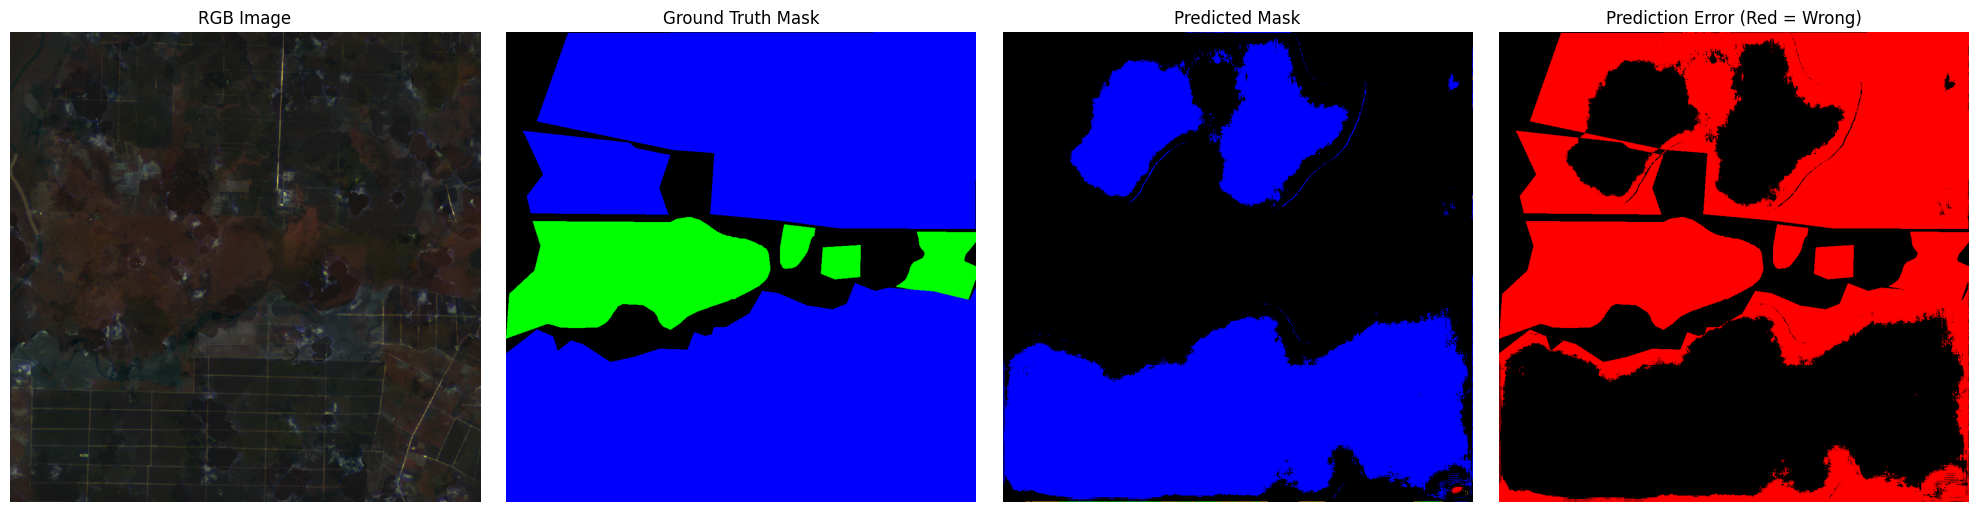

In [13]:
def visualize_validation_sample(model, dataset, sample_idx=0, threshold=0.5):
    model.eval()
    sample = dataset[sample_idx]
    
    image = sample["image"]             # (12, H, W)
    true_mask = sample["mask"]          # (4, H, W)
    image_tensor = torch.from_numpy(image).unsqueeze(0).float().to(model.device)

    with torch.no_grad():
        logits = model(image_tensor)
        pred_mask = (logits.sigmoid() > threshold).squeeze().cpu().numpy()

    rgb = image[[2, 1, 0]].transpose(1, 2, 0)
    rgb_image = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    def mask_to_rgb(mask):
        colors = np.array([
            [0, 255, 0],      # Class 0: green
            [255, 165, 0],    # Class 1: orange
            [255, 0, 0],      # Class 2: red
            [0, 0, 255],      # Class 3: blue
        ])
        h, w = mask.shape[1:]
        color_mask = np.zeros((h, w, 3), dtype=np.uint8)
        for i in range(mask.shape[0]):
            color_mask[mask[i] > 0] = colors[i]
        return color_mask

    def mask_difference(pred, truth):
        diff = (pred != truth).any(axis=0)
        return np.stack([diff*255, np.zeros_like(diff), np.zeros_like(diff)], axis=-1).astype(np.uint8)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(rgb_image)
    axs[0].set_title("RGB Image")
    axs[1].imshow(mask_to_rgb(true_mask))
    axs[1].set_title("Ground Truth Mask")
    axs[2].imshow(mask_to_rgb(pred_mask))
    axs[2].set_title("Predicted Mask")
    axs[3].imshow(mask_difference(pred_mask, true_mask))
    axs[3].set_title("Prediction Error (Red = Wrong)")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

val_dataset = TrainValDataset(
    data_root,
    val_indices,
    augmentations=None,
)

visualize_validation_sample(model, val_dataset, sample_idx=5)

Best prediction:


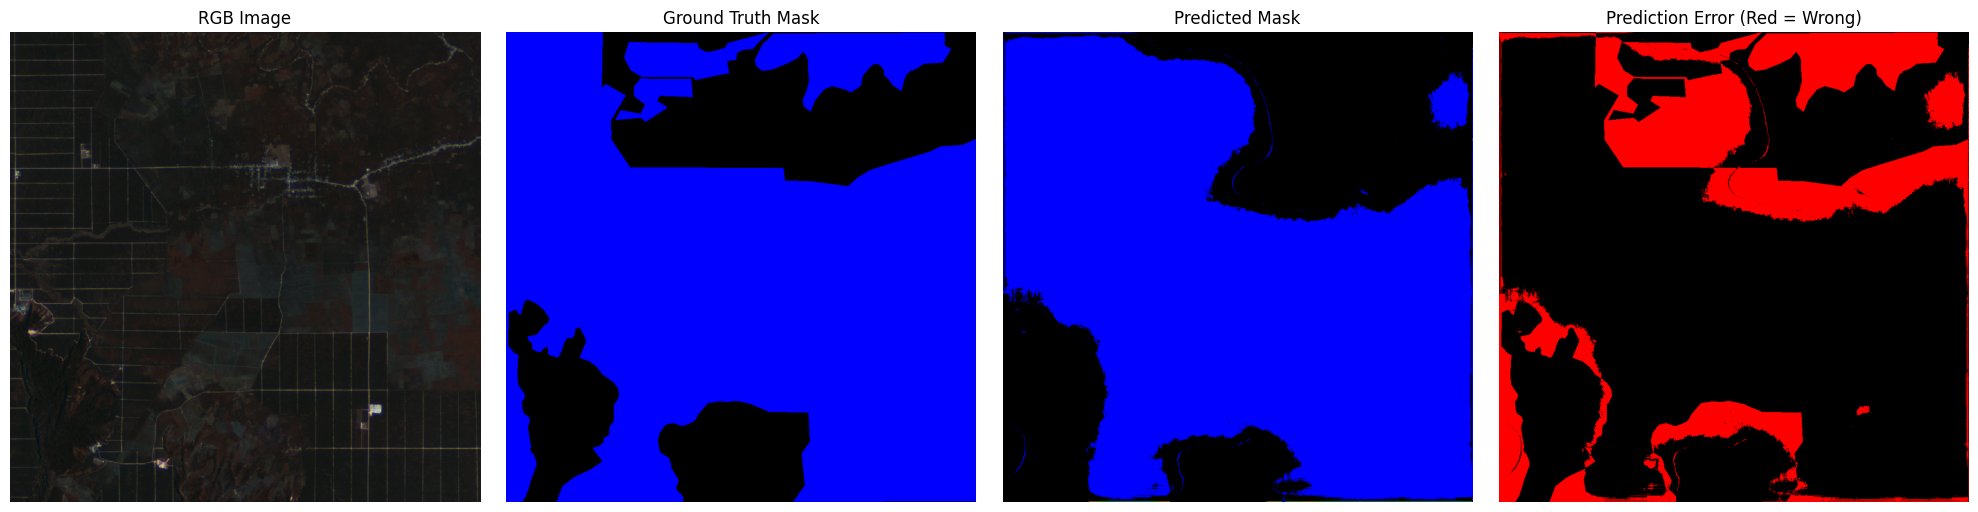

Worst prediction:


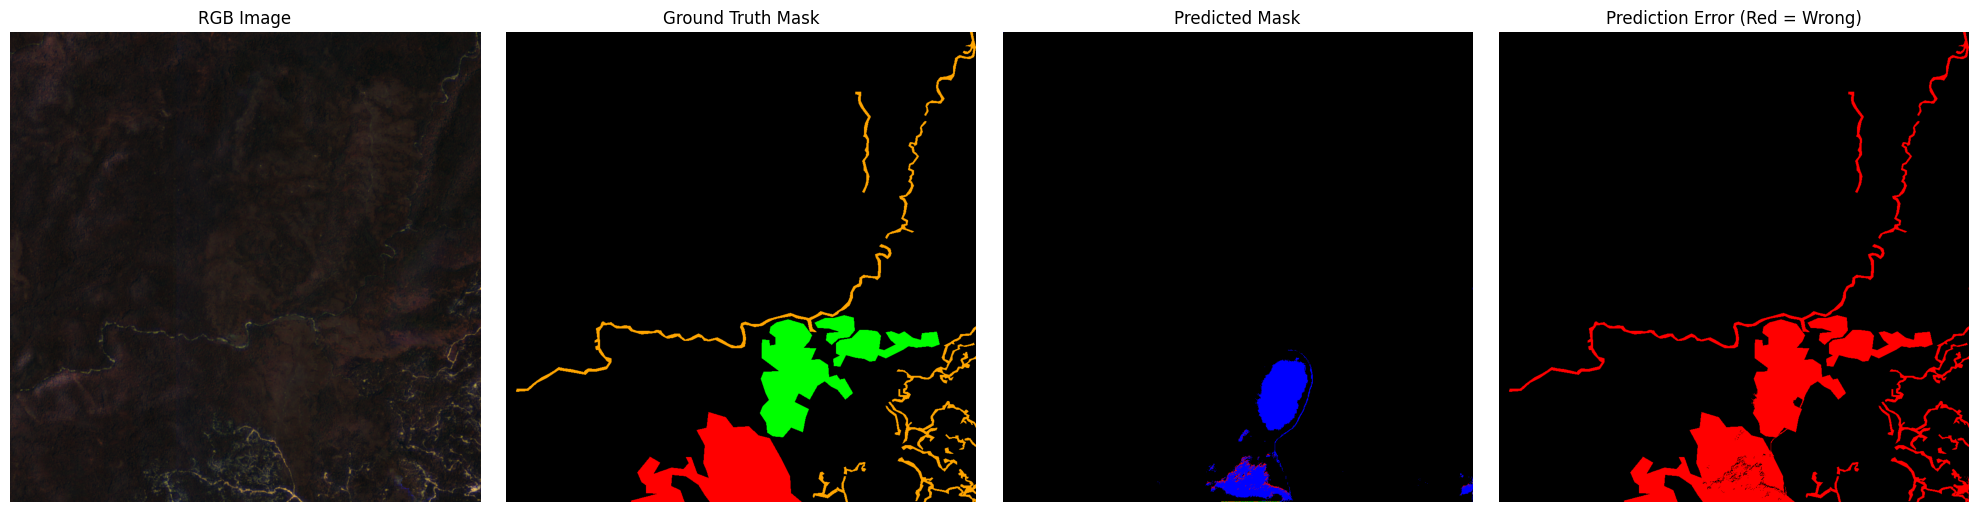

In [14]:
# Get best and worst performing images by overall F1
best_idx = val_f1_scores["all_classes"].idxmax()
worst_idx = val_f1_scores["all_classes"].idxmin()

# Extract the image index from the filename
def extract_index(fn): return int(fn.replace("train_", ""))

best_sample_idx = extract_index(best_idx)
worst_sample_idx = extract_index(worst_idx)

# Visualize both
print("Best prediction:")
visualize_validation_sample(model, val_dataset, sample_idx=val_indices.index(best_sample_idx))

print("Worst prediction:")
visualize_validation_sample(model, val_dataset, sample_idx=val_indices.index(worst_sample_idx))

## Evaluate on test data

In [11]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data_root):
        self.image_paths = []
        for i in range(118):  # evaluation_0.tif to evaluation_117.tif
            self.image_paths.append(data_root / "evaluation_images" / f"evaluation_{i}.tif")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        sample = {
            "image": load_image(self.image_paths[idx]),
        }

        sample["image"] = sample["image"].transpose(2, 0, 1)  # (12, H, W)
        sample["image"] = normalize_image(sample["image"])

        # add metadata
        sample["image_path"] = str(self.image_paths[idx])

        return sample

In [12]:
test_loader = torch.utils.data.DataLoader(
    TestDataset(data_root),
    batch_size=4,
    num_workers=0,
    shuffle=False,
)

test_pred_dir = data_root / "test_preds"
run_inference(model, test_loader, test_pred_dir)

100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


In [13]:
def detect_polygons(pred_dir, score_thresh, min_area):
    pred_dir = Path(pred_dir)
    pred_paths = list(pred_dir.glob("*.npy"))
    pred_paths = sorted(pred_paths)

    polygons_all_imgs = {}
    for pred_path in tqdm(pred_paths):
        polygons_all_classes = {}

        mask = np.load(pred_path)  # (4, 1024, 1024)
        mask = mask > score_thresh  # binarize
        for i, class_name in enumerate(class_names):
            mask_for_a_class = mask[i]
            if mask_for_a_class.sum() < min_area:
                mask_for_a_class = np.zeros_like(mask_for_a_class)  # set all to zero if the predicted area is less than `min_area`

            # extract polygons from the binarized mask
            label = measure.label(mask_for_a_class, connectivity=2, background=0).astype(np.uint8)
            polygons = []
            for p, value in features.shapes(label, label):
                p = shape(p).buffer(0.5)
                p = p.simplify(tolerance=0.5)
                polygons.append(p)
            polygons_all_classes[class_name] = polygons
        polygons_all_imgs[pred_path.name.replace(".npy", ".tif")] = polygons_all_classes

    return polygons_all_imgs

In [14]:
test_pred_polygons = detect_polygons(test_pred_dir, score_thresh=score_thresh, min_area=min_area)

submission_save_path = data_root / f"resnet_imagenet_baseline_50epochs.json"

images = []
for img_id in range(118):  # evaluation_0.tif to evaluation_117.tif
    annotations = []
    for class_name in class_names:
        for poly in test_pred_polygons[f"evaluation_{img_id}.tif"][class_name]:
            seg: list[float] = []  # [x0, y0, x1, y1, ..., xN, yN]
            for xy in poly.exterior.coords:
                seg.extend(xy)

            annotations.append({"class": class_name, "segmentation": seg})

    images.append({"file_name": f"evaluation_{img_id}.tif", "annotations": annotations})

with open(submission_save_path, "w", encoding="utf-8") as f:
    json.dump({"images": images}, f, indent=4)

100%|██████████| 118/118 [00:41<00:00,  2.86it/s]
